# Which version of the website should you use?

## 📖 Background
You work for an early-stage startup in Germany. Your team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site. 

They have been testing the changes for a few weeks and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if it is statistically significant.

## 💾 The data
The team assembled the following file:

#### Redesign test data
- "treatment" - "yes" if the user saw the new version of the landing page, no otherwise.
- "new_images" - "yes" if the page used a new set of images, no otherwise.
- "converted" - 1 if the user joined the site, 0 otherwise.

The control group is those users with "no" in both columns: the old version with the old set of images.

## 💪 Challenge
Complete the following tasks:

1. Analyze the conversion rates for each of the four groups: the new/old design of the landing page and the new/old pictures.
2. Can the increases observed be explained by randomness? (Hint: Think A/B test)
3. Which version of the website should they use?

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df = pd.read_csv('./data/redesign.csv')
df.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


# Q1. Analyze the conversion rates for each of the four groups: new/old design of the landing page and new/old pictures

In [15]:
summary = df['converted'].agg({'mean', 'sum', 'count', 'std'}).reset_index()
summary = summary.transpose()
summary.columns = ['total_converted', 'total_count', 'conversion_rate', 'stdev']
summary.drop('index', axis = 0)

,total_converted,total_count,conversion_rate,stdev
converted,0.317028,40484.0,0.113353,4589.0


In [21]:
gdf = df.groupby(['treatment', 'new_images'])['converted'].agg({'mean', 'sum', 'count', 'std'}).reset_index().sort_values(ascending = False, by = 'mean')
gdf

,treatment,new_images,std,count,mean,sum
2,yes,no,0.325033,10121,0.120047,1215
3,yes,yes,0.317491,10121,0.113724,1151
1,no,yes,0.316043,10121,0.112538,1139
0,no,no,0.309261,10121,0.107104,1084


In [63]:
gdf = df.groupby(['treatment', 'new_images'])['converted'].agg({'mean', 'sum', 'count', 'std'}).reset_index()
gdf.columns = ['treatment', 'new_images', 'std', 'total_count', 'conversion_rate', 'total_converted']
gdf['treatment'] = gdf['treatment'].apply(lambda x: x.upper())
gdf['new_images'] = gdf['new_images'].apply(lambda x: x.upper())
gdf['group'] = gdf['treatment'] + ' treatment' + ' | ' + gdf['new_images'] + ' new_images '
gdf = gdf.sort_values(by = 'conversion_rate', ascending = False)
gdf

,treatment,new_images,std,total_count,conversion_rate,total_converted,group
2,YES,NO,0.325033,10121,0.120047,1215,YES treatment | NO new_images
3,YES,YES,0.317491,10121,0.113724,1151,YES treatment | YES new_images
1,NO,YES,0.316043,10121,0.112538,1139,NO treatment | YES new_images
0,NO,NO,0.309261,10121,0.107104,1084,NO treatment | NO new_images


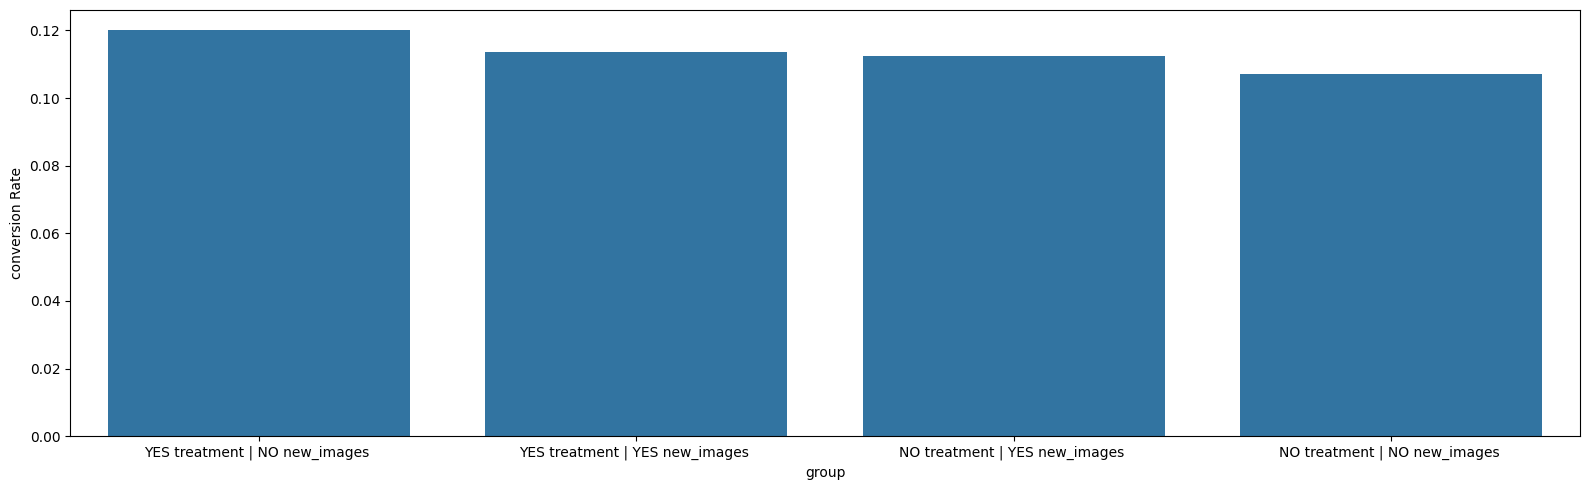

In [64]:
plt.figure(figsize = ( 16, 5 ))
sns.barplot(gdf, x = 'group', y = 'conversion_rate')

plt.ylabel('conversion Rate')
plt.tight_layout()

# Q2. Can increases observed be explained by randomness?

## Chi-Square Test

In [66]:
def chi_squared_test(group1, group2):
    contingency_table = [
        [group1['total_converted'], group1['total_count'] - group1['total_converted']],
        [group2['total_converted'], group2['total_count'] - group2['total_converted']]
    ]

    chi2, p, _, _ = chi2_contingency(contingency_table)
    return chi2, p

labels = [
    ("YES treatment, NO new_images", "Control Group"),
    ("YES treatment, YES new_images", "Control Group"),
    ("NO treatment, YES new_images", "Control Group"),
]

groups_for_comparison = [
    (gdf.iloc[0], gdf.iloc[3]),
    (gdf.iloc[1], gdf.iloc[3]),
    (gdf.iloc[2], gdf.iloc[3]),
]

test_results = []
for (label1, label2), (group1, group2) in zip(labels, groups_for_comparison):
    chi2, p = chi_squared_test(group1, group2)
    result = {
        'Comparison': f"{label1} vs. {label2}",
        'Chi-Squared': chi2,
        'P-Value': p
    }
    test_results.append(result)

pd.DataFrame(test_results).sort_values("P-Value")

,Comparison,Chi-Squared,P-Value
0,"YES treatment, NO new_images vs. Control Group",8.292894,0.003980
1,"YES treatment, YES new_images vs. Control Group",2.190899,0.138828
2,"NO treatment, YES new_images vs. Control Group",1.473570,0.224783


**Results**
---
The low P-value of the Chi-square test for New Design, Old Images vs. Control Group (0.00398) suggests that the difference between these two group is statistically signifcant at the 95% level (i.e. a p-value < 0.05). These values indicate whether the observed differences between groups can be explained by randomness. A p-value less than 0.05 typically indicates that the observed difference is statistically significant and unlikely due to random chance. Conversely, a p-value greater than 0.05 suggests that the observed differences could be due to randomness.

Thus, the redesign of the landing page (without the new images) appears to have a statistically significant positive impact on conversion rates. The new images alone or in combination with the new design do not show a statistically significant effec

## Z-test for Proportions

In [67]:
count = np.array([
    df[(df['treatment'] == 'yes') & (df['new_images'] == 'no') & (df['converted'] == 1)].shape[0],
    df[(df['treatment'] == 'no') & (df['new_images'] == 'no') & (df['converted'] == 1)].shape[0]
])

nobs = np.array([
    df[(df['treatment'] == 'yes') & (df['new_images'] == 'no')].shape[0],
    df[(df['treatment'] == 'no') & (df['new_images'] == 'no')].shape[0]
])

# Perform the z-test for proportions
stat, pval = proportions_ztest(count, nobs)

print('z-statistic:', stat)
print('p-value:', pval)

z-statistic: 2.9018903061123846
p-value: 0.0037091839675173722


**Result**
A z-statistic of 2.90 indicates that the difference in conversion rates between the new and old design (while keeping images old) is 2.90 standard deviations away from the hypothesized mean difference of zero. This is a measure of how extreme the observed result is, assuming there was no actual difference between the two designs.

A p-value of 0.0037 suggests that such a result would be very unlikely if the new design did not actually affect conversions. Specifically, there's only a 0.37% chance of seeing this difference by random chance if the new design had no effect.

The results are statistically significant, as the p-value (0.0037) is less than 0.05, the conventional threshold for significance in many scientific studies. This implies that the observed increase in the conversion rate with the new landing page design, compared to the old one, is likely not due to random variation but rather a true effect of the redesign. Therefore, we have evidence to support that the new design of the landing page is more effective at converting visitors than the old design, under the condition of using the old images. 

# Q3. Which version of the website should they use?

Based on the aforementioned statistical analyses, the company should employ a website with new design and old images as such design was associated with the higest conversion rate.